In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [5]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [6]:
class Edge1(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05


In [7]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.add_subdomain(Edge1(), 2)
        self.add_subdomain(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        sd = self.mesh.sd
        left = numpy.sum(vol[sd == 2])
        right = numpy.sum(vol[sd == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [8]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [9]:
model.listOfReactions

OrderedDict([('rxn2f0a4161_7b2f_4f08_a8be_28cd5c8c86ba',
              <spatialpy.Model.Reaction at 0x7f04134466d0>),
             ('rxn0a1d481d_8cff_4de0_9edb_c575e05d0eff',
              <spatialpy.Model.Reaction at 0x7f0413446700>),
             ('rxn0ed75c68_48df_4274_b5c9_09b05a7844af',
              <spatialpy.Model.Reaction at 0x7f0413446520>)])

In [10]:
from spatialpy.nsmsolver import NSMSolver

In [11]:
#result = model.run(report_level=2)
sol = NSMSolver(model, report_level=2)
sol.h = 0.8
print("h="+str(sol.h))
%time sol.compile()

h=0.8
Compiling Solver.  Build dir: /tmp/spatialpy_build_nch55tdl
Creating propensity file /tmp/spatialpy_build_nch55tdl/cylinder_demo3d_generated_model.c
cmd: cd /tmp/spatialpy_build_nch55tdl ; make -f /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile.nsm ROOT=/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/spatialpy_build_nch55tdl/cylinder_demo3d_generated_model.c BUILD=/tmp/spatialpy_build_nch55tdl

gcc -c -o linked_list.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o particle.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o simulate.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sd

In [12]:
%time result = sol.run()

cmd: cd /tmp/spatialpy_result_69jh5o4w;/tmp/spatialpy_build_nch55tdl/ssa_sdpd

Elapsed seconds: 2.20

CPU times: user 6.16 ms, sys: 0 ns, total: 6.16 ms
Wall time: 2.2 s


read_step(0) opening '/tmp/spatialpy_result_69jh5o4w/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_69jh5o4w/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_69jh5o4w/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_69jh5o4w/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_69jh5o4w/output4.vtk'
read_step(5) opening '/tmp/spatialpy_result_69jh5o4w/output5.vtk'
read_step(6) opening '/tmp/spatialpy_result_69jh5o4w/output6.vtk'
read_step(7) opening '/tmp/spatialpy_result_69jh5o4w/output7.vtk'
read_step(8) opening '/tmp/spatialpy_result_69jh5o4w/output8.vtk'
read_step(9) opening '/tmp/spatialpy_result_69jh5o4w/output9.vtk'
read_step(10) opening '/tmp/spatialpy_result_69jh5o4w/output10.vtk'
read_step(11) opening '/tmp/spatialpy_result_69jh5o4w/output11.vtk'
read_step(12) opening '/tmp/spatialpy_result_69jh5o4w/output12.vtk'
read_step(13) opening '/tmp/spatialpy_result_69jh5o4w/output13.vtk'
read_step(14) opening '/tmp/spatialpy_result_69jh5o4w/output14.vtk'


read_step(175) opening '/tmp/spatialpy_result_69jh5o4w/output175.vtk'
read_step(176) opening '/tmp/spatialpy_result_69jh5o4w/output176.vtk'
read_step(177) opening '/tmp/spatialpy_result_69jh5o4w/output177.vtk'
read_step(178) opening '/tmp/spatialpy_result_69jh5o4w/output178.vtk'
read_step(179) opening '/tmp/spatialpy_result_69jh5o4w/output179.vtk'
read_step(180) opening '/tmp/spatialpy_result_69jh5o4w/output180.vtk'
read_step(181) opening '/tmp/spatialpy_result_69jh5o4w/output181.vtk'
read_step(182) opening '/tmp/spatialpy_result_69jh5o4w/output182.vtk'
read_step(183) opening '/tmp/spatialpy_result_69jh5o4w/output183.vtk'
read_step(184) opening '/tmp/spatialpy_result_69jh5o4w/output184.vtk'
read_step(185) opening '/tmp/spatialpy_result_69jh5o4w/output185.vtk'
read_step(186) opening '/tmp/spatialpy_result_69jh5o4w/output186.vtk'
read_step(187) opening '/tmp/spatialpy_result_69jh5o4w/output187.vtk'
read_step(188) opening '/tmp/spatialpy_result_69jh5o4w/output188.vtk'
read_step(189) openi

read_step(305) opening '/tmp/spatialpy_result_69jh5o4w/output305.vtk'
read_step(306) opening '/tmp/spatialpy_result_69jh5o4w/output306.vtk'
read_step(307) opening '/tmp/spatialpy_result_69jh5o4w/output307.vtk'
read_step(308) opening '/tmp/spatialpy_result_69jh5o4w/output308.vtk'
read_step(309) opening '/tmp/spatialpy_result_69jh5o4w/output309.vtk'
read_step(310) opening '/tmp/spatialpy_result_69jh5o4w/output310.vtk'
read_step(311) opening '/tmp/spatialpy_result_69jh5o4w/output311.vtk'
read_step(312) opening '/tmp/spatialpy_result_69jh5o4w/output312.vtk'
read_step(313) opening '/tmp/spatialpy_result_69jh5o4w/output313.vtk'
read_step(314) opening '/tmp/spatialpy_result_69jh5o4w/output314.vtk'
read_step(315) opening '/tmp/spatialpy_result_69jh5o4w/output315.vtk'
read_step(316) opening '/tmp/spatialpy_result_69jh5o4w/output316.vtk'
read_step(317) opening '/tmp/spatialpy_result_69jh5o4w/output317.vtk'
read_step(318) opening '/tmp/spatialpy_result_69jh5o4w/output318.vtk'
read_step(319) openi

read_step(425) opening '/tmp/spatialpy_result_69jh5o4w/output425.vtk'
read_step(426) opening '/tmp/spatialpy_result_69jh5o4w/output426.vtk'
read_step(427) opening '/tmp/spatialpy_result_69jh5o4w/output427.vtk'
read_step(428) opening '/tmp/spatialpy_result_69jh5o4w/output428.vtk'
read_step(429) opening '/tmp/spatialpy_result_69jh5o4w/output429.vtk'
read_step(430) opening '/tmp/spatialpy_result_69jh5o4w/output430.vtk'
read_step(431) opening '/tmp/spatialpy_result_69jh5o4w/output431.vtk'
read_step(432) opening '/tmp/spatialpy_result_69jh5o4w/output432.vtk'
read_step(433) opening '/tmp/spatialpy_result_69jh5o4w/output433.vtk'
read_step(434) opening '/tmp/spatialpy_result_69jh5o4w/output434.vtk'
read_step(435) opening '/tmp/spatialpy_result_69jh5o4w/output435.vtk'
read_step(436) opening '/tmp/spatialpy_result_69jh5o4w/output436.vtk'
read_step(437) opening '/tmp/spatialpy_result_69jh5o4w/output437.vtk'
read_step(438) opening '/tmp/spatialpy_result_69jh5o4w/output438.vtk'
read_step(439) openi

read_step(45) opening '/tmp/spatialpy_result_69jh5o4w/output45.vtk'
read_step(46) opening '/tmp/spatialpy_result_69jh5o4w/output46.vtk'
read_step(47) opening '/tmp/spatialpy_result_69jh5o4w/output47.vtk'
read_step(48) opening '/tmp/spatialpy_result_69jh5o4w/output48.vtk'
read_step(49) opening '/tmp/spatialpy_result_69jh5o4w/output49.vtk'
read_step(50) opening '/tmp/spatialpy_result_69jh5o4w/output50.vtk'
read_step(51) opening '/tmp/spatialpy_result_69jh5o4w/output51.vtk'
read_step(52) opening '/tmp/spatialpy_result_69jh5o4w/output52.vtk'
read_step(53) opening '/tmp/spatialpy_result_69jh5o4w/output53.vtk'
read_step(54) opening '/tmp/spatialpy_result_69jh5o4w/output54.vtk'
read_step(55) opening '/tmp/spatialpy_result_69jh5o4w/output55.vtk'
read_step(56) opening '/tmp/spatialpy_result_69jh5o4w/output56.vtk'
read_step(57) opening '/tmp/spatialpy_result_69jh5o4w/output57.vtk'
read_step(58) opening '/tmp/spatialpy_result_69jh5o4w/output58.vtk'
read_step(59) opening '/tmp/spatialpy_result_69j

read_step(165) opening '/tmp/spatialpy_result_69jh5o4w/output165.vtk'
read_step(166) opening '/tmp/spatialpy_result_69jh5o4w/output166.vtk'
read_step(167) opening '/tmp/spatialpy_result_69jh5o4w/output167.vtk'
read_step(168) opening '/tmp/spatialpy_result_69jh5o4w/output168.vtk'
read_step(169) opening '/tmp/spatialpy_result_69jh5o4w/output169.vtk'
read_step(170) opening '/tmp/spatialpy_result_69jh5o4w/output170.vtk'
read_step(171) opening '/tmp/spatialpy_result_69jh5o4w/output171.vtk'
read_step(172) opening '/tmp/spatialpy_result_69jh5o4w/output172.vtk'
read_step(173) opening '/tmp/spatialpy_result_69jh5o4w/output173.vtk'
read_step(174) opening '/tmp/spatialpy_result_69jh5o4w/output174.vtk'
read_step(175) opening '/tmp/spatialpy_result_69jh5o4w/output175.vtk'
read_step(176) opening '/tmp/spatialpy_result_69jh5o4w/output176.vtk'
read_step(177) opening '/tmp/spatialpy_result_69jh5o4w/output177.vtk'
read_step(178) opening '/tmp/spatialpy_result_69jh5o4w/output178.vtk'
read_step(179) openi

read_step(327) opening '/tmp/spatialpy_result_69jh5o4w/output327.vtk'
read_step(328) opening '/tmp/spatialpy_result_69jh5o4w/output328.vtk'
read_step(329) opening '/tmp/spatialpy_result_69jh5o4w/output329.vtk'
read_step(330) opening '/tmp/spatialpy_result_69jh5o4w/output330.vtk'
read_step(331) opening '/tmp/spatialpy_result_69jh5o4w/output331.vtk'
read_step(332) opening '/tmp/spatialpy_result_69jh5o4w/output332.vtk'
read_step(333) opening '/tmp/spatialpy_result_69jh5o4w/output333.vtk'
read_step(334) opening '/tmp/spatialpy_result_69jh5o4w/output334.vtk'
read_step(335) opening '/tmp/spatialpy_result_69jh5o4w/output335.vtk'
read_step(336) opening '/tmp/spatialpy_result_69jh5o4w/output336.vtk'
read_step(337) opening '/tmp/spatialpy_result_69jh5o4w/output337.vtk'
read_step(338) opening '/tmp/spatialpy_result_69jh5o4w/output338.vtk'
read_step(339) opening '/tmp/spatialpy_result_69jh5o4w/output339.vtk'
read_step(340) opening '/tmp/spatialpy_result_69jh5o4w/output340.vtk'
read_step(341) openi

read_step(493) opening '/tmp/spatialpy_result_69jh5o4w/output493.vtk'
read_step(494) opening '/tmp/spatialpy_result_69jh5o4w/output494.vtk'
read_step(495) opening '/tmp/spatialpy_result_69jh5o4w/output495.vtk'
read_step(496) opening '/tmp/spatialpy_result_69jh5o4w/output496.vtk'
read_step(497) opening '/tmp/spatialpy_result_69jh5o4w/output497.vtk'
read_step(498) opening '/tmp/spatialpy_result_69jh5o4w/output498.vtk'
read_step(499) opening '/tmp/spatialpy_result_69jh5o4w/output499.vtk'
read_step(0) opening '/tmp/spatialpy_result_69jh5o4w/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_69jh5o4w/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_69jh5o4w/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_69jh5o4w/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_69jh5o4w/output4.vtk'
read_step(5) opening '/tmp/spatialpy_result_69jh5o4w/output5.vtk'
read_step(6) opening '/tmp/spatialpy_result_69jh5o4w/output6.vtk'
read_step(7) opening '/tmp/spatialpy_result_69jh

read_step(160) opening '/tmp/spatialpy_result_69jh5o4w/output160.vtk'
read_step(161) opening '/tmp/spatialpy_result_69jh5o4w/output161.vtk'
read_step(162) opening '/tmp/spatialpy_result_69jh5o4w/output162.vtk'
read_step(163) opening '/tmp/spatialpy_result_69jh5o4w/output163.vtk'
read_step(164) opening '/tmp/spatialpy_result_69jh5o4w/output164.vtk'
read_step(165) opening '/tmp/spatialpy_result_69jh5o4w/output165.vtk'
read_step(166) opening '/tmp/spatialpy_result_69jh5o4w/output166.vtk'
read_step(167) opening '/tmp/spatialpy_result_69jh5o4w/output167.vtk'
read_step(168) opening '/tmp/spatialpy_result_69jh5o4w/output168.vtk'
read_step(169) opening '/tmp/spatialpy_result_69jh5o4w/output169.vtk'
read_step(170) opening '/tmp/spatialpy_result_69jh5o4w/output170.vtk'
read_step(171) opening '/tmp/spatialpy_result_69jh5o4w/output171.vtk'
read_step(172) opening '/tmp/spatialpy_result_69jh5o4w/output172.vtk'
read_step(173) opening '/tmp/spatialpy_result_69jh5o4w/output173.vtk'
read_step(174) openi

read_step(278) opening '/tmp/spatialpy_result_69jh5o4w/output278.vtk'
read_step(279) opening '/tmp/spatialpy_result_69jh5o4w/output279.vtk'
read_step(280) opening '/tmp/spatialpy_result_69jh5o4w/output280.vtk'
read_step(281) opening '/tmp/spatialpy_result_69jh5o4w/output281.vtk'
read_step(282) opening '/tmp/spatialpy_result_69jh5o4w/output282.vtk'
read_step(283) opening '/tmp/spatialpy_result_69jh5o4w/output283.vtk'
read_step(284) opening '/tmp/spatialpy_result_69jh5o4w/output284.vtk'
read_step(285) opening '/tmp/spatialpy_result_69jh5o4w/output285.vtk'
read_step(286) opening '/tmp/spatialpy_result_69jh5o4w/output286.vtk'
read_step(287) opening '/tmp/spatialpy_result_69jh5o4w/output287.vtk'
read_step(288) opening '/tmp/spatialpy_result_69jh5o4w/output288.vtk'
read_step(289) opening '/tmp/spatialpy_result_69jh5o4w/output289.vtk'
read_step(290) opening '/tmp/spatialpy_result_69jh5o4w/output290.vtk'
read_step(291) opening '/tmp/spatialpy_result_69jh5o4w/output291.vtk'
read_step(292) openi

read_step(397) opening '/tmp/spatialpy_result_69jh5o4w/output397.vtk'
read_step(398) opening '/tmp/spatialpy_result_69jh5o4w/output398.vtk'
read_step(399) opening '/tmp/spatialpy_result_69jh5o4w/output399.vtk'
read_step(400) opening '/tmp/spatialpy_result_69jh5o4w/output400.vtk'
read_step(401) opening '/tmp/spatialpy_result_69jh5o4w/output401.vtk'
read_step(402) opening '/tmp/spatialpy_result_69jh5o4w/output402.vtk'
read_step(403) opening '/tmp/spatialpy_result_69jh5o4w/output403.vtk'
read_step(404) opening '/tmp/spatialpy_result_69jh5o4w/output404.vtk'
read_step(405) opening '/tmp/spatialpy_result_69jh5o4w/output405.vtk'
read_step(406) opening '/tmp/spatialpy_result_69jh5o4w/output406.vtk'
read_step(407) opening '/tmp/spatialpy_result_69jh5o4w/output407.vtk'
read_step(408) opening '/tmp/spatialpy_result_69jh5o4w/output408.vtk'
read_step(409) opening '/tmp/spatialpy_result_69jh5o4w/output409.vtk'
read_step(410) opening '/tmp/spatialpy_result_69jh5o4w/output410.vtk'
read_step(411) openi

read_step(63) opening '/tmp/spatialpy_result_69jh5o4w/output63.vtk'
read_step(64) opening '/tmp/spatialpy_result_69jh5o4w/output64.vtk'
read_step(65) opening '/tmp/spatialpy_result_69jh5o4w/output65.vtk'
read_step(66) opening '/tmp/spatialpy_result_69jh5o4w/output66.vtk'
read_step(67) opening '/tmp/spatialpy_result_69jh5o4w/output67.vtk'
read_step(68) opening '/tmp/spatialpy_result_69jh5o4w/output68.vtk'
read_step(69) opening '/tmp/spatialpy_result_69jh5o4w/output69.vtk'
read_step(70) opening '/tmp/spatialpy_result_69jh5o4w/output70.vtk'
read_step(71) opening '/tmp/spatialpy_result_69jh5o4w/output71.vtk'
read_step(72) opening '/tmp/spatialpy_result_69jh5o4w/output72.vtk'
read_step(73) opening '/tmp/spatialpy_result_69jh5o4w/output73.vtk'
read_step(74) opening '/tmp/spatialpy_result_69jh5o4w/output74.vtk'
read_step(75) opening '/tmp/spatialpy_result_69jh5o4w/output75.vtk'
read_step(76) opening '/tmp/spatialpy_result_69jh5o4w/output76.vtk'
read_step(77) opening '/tmp/spatialpy_result_69j

read_step(221) opening '/tmp/spatialpy_result_69jh5o4w/output221.vtk'
read_step(222) opening '/tmp/spatialpy_result_69jh5o4w/output222.vtk'
read_step(223) opening '/tmp/spatialpy_result_69jh5o4w/output223.vtk'
read_step(224) opening '/tmp/spatialpy_result_69jh5o4w/output224.vtk'
read_step(225) opening '/tmp/spatialpy_result_69jh5o4w/output225.vtk'
read_step(226) opening '/tmp/spatialpy_result_69jh5o4w/output226.vtk'
read_step(227) opening '/tmp/spatialpy_result_69jh5o4w/output227.vtk'
read_step(228) opening '/tmp/spatialpy_result_69jh5o4w/output228.vtk'
read_step(229) opening '/tmp/spatialpy_result_69jh5o4w/output229.vtk'
read_step(230) opening '/tmp/spatialpy_result_69jh5o4w/output230.vtk'
read_step(231) opening '/tmp/spatialpy_result_69jh5o4w/output231.vtk'
read_step(232) opening '/tmp/spatialpy_result_69jh5o4w/output232.vtk'
read_step(233) opening '/tmp/spatialpy_result_69jh5o4w/output233.vtk'
read_step(234) opening '/tmp/spatialpy_result_69jh5o4w/output234.vtk'
read_step(235) openi

read_step(384) opening '/tmp/spatialpy_result_69jh5o4w/output384.vtk'
read_step(385) opening '/tmp/spatialpy_result_69jh5o4w/output385.vtk'
read_step(386) opening '/tmp/spatialpy_result_69jh5o4w/output386.vtk'
read_step(387) opening '/tmp/spatialpy_result_69jh5o4w/output387.vtk'
read_step(388) opening '/tmp/spatialpy_result_69jh5o4w/output388.vtk'
read_step(389) opening '/tmp/spatialpy_result_69jh5o4w/output389.vtk'
read_step(390) opening '/tmp/spatialpy_result_69jh5o4w/output390.vtk'
read_step(391) opening '/tmp/spatialpy_result_69jh5o4w/output391.vtk'
read_step(392) opening '/tmp/spatialpy_result_69jh5o4w/output392.vtk'
read_step(393) opening '/tmp/spatialpy_result_69jh5o4w/output393.vtk'
read_step(394) opening '/tmp/spatialpy_result_69jh5o4w/output394.vtk'
read_step(395) opening '/tmp/spatialpy_result_69jh5o4w/output395.vtk'
read_step(396) opening '/tmp/spatialpy_result_69jh5o4w/output396.vtk'
read_step(397) opening '/tmp/spatialpy_result_69jh5o4w/output397.vtk'
read_step(398) openi

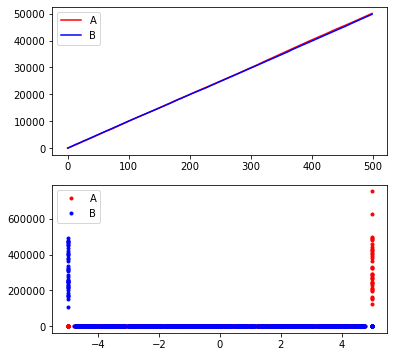

In [13]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
sd = model.mesh.sd
print(numpy.sum(vol[sd == 2]))
print(numpy.sum(vol[sd == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')
